In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

import wrangle

## Acquire Data

In [4]:
df = wrangle.wrangle_telco()
df.head()

,customer_id,monthly_charges,tenure,total_charges
0,0013-SMEOE,109.70,71,7904.25
1,0014-BMAQU,84.65,63,5377.80
2,0016-QLJIS,90.45,65,5957.90
3,0017-DINOC,45.20,54,2460.55
4,0017-IUDMW,116.80,72,8456.75


In [5]:
query = '''select * from customers'''
df2 = wrangle.get_data_from_sql('telco_churn', query)

In [6]:
df2.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service_type_id',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract_type_id',
       'paperless_billing', 'payment_type_id', 'monthly_charges',
       'total_charges', 'churn'],
      dtype='object')

### Create New Feature

Write a function, months_to_years(tenure_months, df) that returns your dataframe with a new feature tenure_years, in complete years as a customer.

In [7]:
def months_to_years(df):
    """
    Takes in the telco df and returns the df with new 
    categorical feature 'tenure_years'
    """
    df['tenure_years'] = round(df.tenure // 12)
    df['tenure_years'] = df.tenure_years.astype('object')
    return df

In [8]:
df = months_to_years(df)
df.head()

,customer_id,monthly_charges,tenure,total_charges,tenure_years
0,0013-SMEOE,109.70,71,7904.25,5
1,0014-BMAQU,84.65,63,5377.80,5
2,0016-QLJIS,90.45,65,5957.90,5
3,0017-DINOC,45.20,54,2460.55,4
4,0017-IUDMW,116.80,72,8456.75,6


In [9]:
df.tenure_years.value_counts()

5    676
6    343
4    265
3    166
2    103
1     83
0     59
Name: tenure_years, dtype: int64

In [10]:
# Validate our data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1695 entries, 0 to 1694
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      1695 non-null   object 
 1   monthly_charges  1695 non-null   float64
 2   tenure           1695 non-null   int64  
 3   total_charges    1695 non-null   float64
 4   tenure_years     1695 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 66.3+ KB


#### Split Data to Explore

In [11]:
# Split into train, validate, and test sets.

train, validate, test = wrangle.split_continuous(df)

train -> (949, 5)
validate -> (407, 5)
test -> (339, 5)


### `.pairplot`

In [12]:
telco_cols = ['monthly_charges', 'tenure', 'total_charges']
descriptive = {'monthly_charges': 'Monthly Charges ($)',
               'tenure': 'Tenure (months)',
               'total_charges': 'Total Charges ($)',
               'tenure_years': 'Tenure (years)',
              '':''}

In [13]:
def plot_variable_pairs(train, cols, descriptive=None, hue=None):
    '''
    This function takes in a df, a list of cols to plot, and default hue=None 
    and displays a pairplot with a red regression line. If passed a descriptive
    dictionary, converts axis titles to the corresponding names.
    '''
    # sets line-plot options and scatter-plot options
    keyword_arguments={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}}
    
    # creates pairplot object
    pairplot = sns.pairplot(train[cols], hue=hue, kind="reg",\
            plot_kws=keyword_arguments)
    
    # if passed a descriptive dictionary, iterates through matplotlib axes
    # in our pairplot object and sets their axis labels to the corresponding 
    # strings.
    if descriptive:
        for ax in pairplot.axes.flat:
            ax.set_xlabel(descriptive[ax.get_xlabel()])
            ax.set_ylabel(descriptive[ax.get_ylabel()])
    
    # Adds a super-title
    pairplot.fig.suptitle('Correlation of Continuous Variables', y=1.08)
    plt.show()

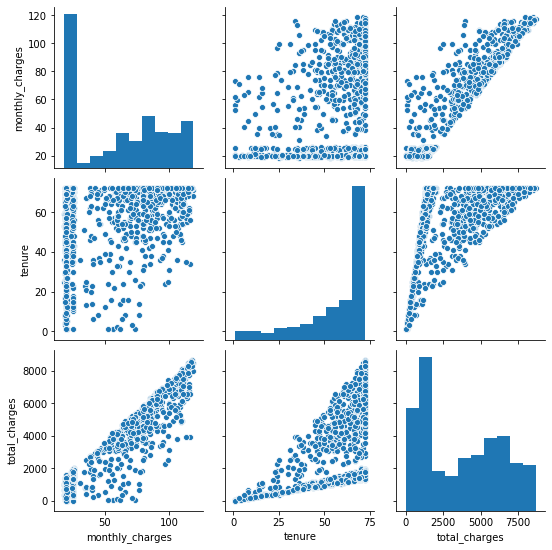

In [14]:
pairplot = sns.pairplot(train[telco_cols])
pairplot

In [18]:
for i in pairplot.axes.flat:
    print(i)

AxesSubplot(0.0699653,0.693769;0.275945x0.298823)
AxesSubplot(0.386767,0.693769;0.275945x0.298823)
AxesSubplot(0.703569,0.693769;0.275945x0.298823)
AxesSubplot(0.0699653,0.376427;0.275945x0.298823)
AxesSubplot(0.386767,0.376427;0.275945x0.298823)
AxesSubplot(0.703569,0.376427;0.275945x0.298823)
AxesSubplot(0.0699653,0.0590856;0.275945x0.298823)
AxesSubplot(0.386767,0.0590856;0.275945x0.298823)
AxesSubplot(0.703569,0.0590856;0.275945x0.298823)


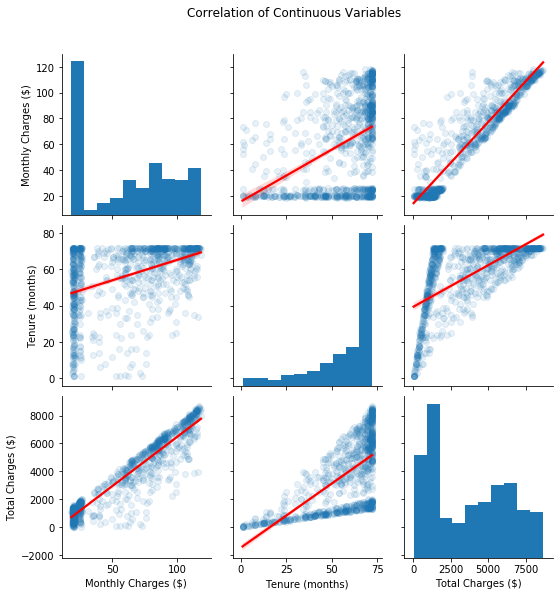

In [37]:
plot_variable_pairs(train, telco_cols, descriptive)

In [39]:
def plot_pairplot(train, cols, descriptive=None, hue=None):
    '''
    Take in train df, list of columns to plot, and hue=None
    and display scatter plots and hists.
    '''
    pairplot = sns.pairplot(train[cols], corner=True)
    pairplot.axes.flat[0].set_ylabel(cols[0])
    if descriptive:
        for ax in pairplot.axes.flat:
            if ax:
                ax.set_xlabel(descriptive[ax.get_xlabel()])
                ax.set_ylabel(descriptive[ax.get_ylabel()])
    pairplot.fig.suptitle('Correlation of Continuous Variables', y=1.08)
    plt.show()

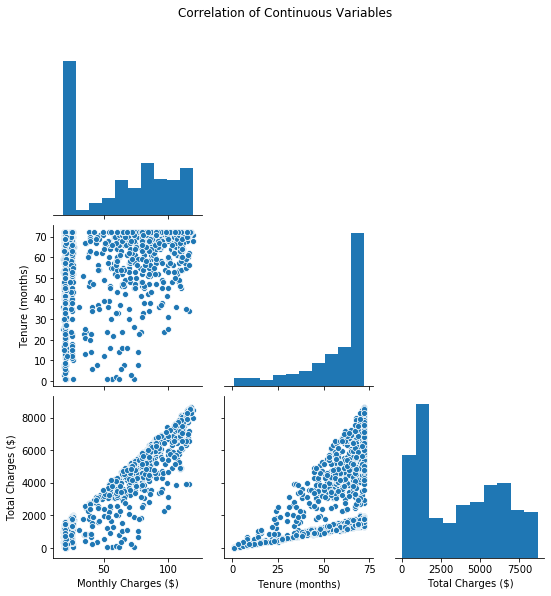

In [41]:
plot_pairplot(train, telco_cols, descriptive=descriptive)

### `.heatmap`

In [42]:
train[telco_cols].corr()

,monthly_charges,tenure,total_charges
monthly_charges,1.000000,0.425131,0.941523
tenure,0.425131,1.000000,0.650237
total_charges,0.941523,0.650237,1.000000


In [21]:
def create_heatmap(train, cols, descriptive=None):
    corr_matrix = train[cols].corr()
    
    kwargs = {'alpha':.9,'linewidth':3, 'linestyle':'-', 
          'linecolor':'k','rasterized':False, 'edgecolor':'w', 
          'capstyle':'projecting',}
    labels = pd.Series(cols)
    if descriptive:
        labels = labels.map(descriptive)
    plt.figure(figsize=(8,6))
    heatmap = sns.heatmap(corr_matrix, cmap='Purples', annot=True, \
                          xticklabels=labels, yticklabels=labels, **kwargs)
    plt.ylim(0, 3)
    plt.title('Correlation of Continuous Variables')
    plt.show()

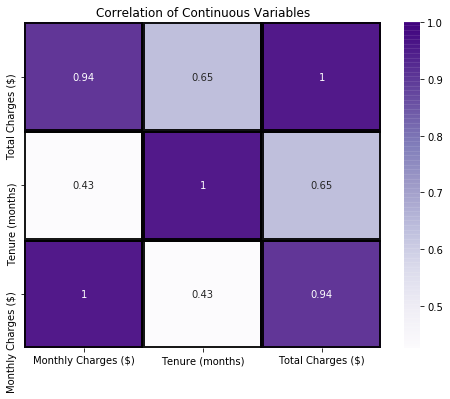

In [22]:
create_heatmap(train, telco_cols, descriptive)

### Convert Data Types

In [45]:
train['tenure_years'] = train.tenure_years.astype('object')
validate['tenure_years'] = validate.tenure_years.astype('object')
test['tenure_years'] = test.tenure_years.astype('object')

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 949 entries, 1256 to 1593
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      949 non-null    object 
 1   monthly_charges  949 non-null    float64
 2   tenure           949 non-null    int64  
 3   total_charges    949 non-null    float64
 4   tenure_years     949 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 84.5+ KB


## Plot Categorical and Continous Variables

Write a function that takes in a string name of a categorical variable, a string name from a continuous variable and the df they live in, (categorical_var, continuous_var, df), and outputs 3 different plots for plotting a categorical variable with a continuous variable.

- For Example: tenure_years with total_charges. 


- For ideas on effective ways to visualize categorical with continuous: https://datavizcatalogue.com/. You can then look into seaborn and matplotlib documentation for ways to create plots.

In [128]:
def plot_categorical_and_continuous_vars(categorical_vars, continuous_vars, df, descriptive=None):
    """
    This function that takes in a string name of a categorical variable, 
    a string name from a continuous variable and the df they live in and
    displays 4 different plots.
    """
    for categorical_var in categorical_vars:
        for continuous_var in continuous_vars:
            categorical_label = categorical_var
            continuous_label = continuous_var

            if descriptive:
                categorical_label = descriptive[categorical_var]
                continuous_label = descriptive[continuous_var]
                
            fig, axes = plt.subplots(figsize=(12,36), nrows=4,ncols=1)
            fig.suptitle(f'{continuous_label} by {categorical_label}', fontsize=18, y=1.02)

            sns.lineplot(ax=axes[0], x=categorical_var, y=continuous_var, data=df)
            axes[0].set_title('Line Plot', fontsize=14)
            axes[0].set_xlabel(categorical_label, fontsize=12)
            axes[0].set_ylabel(continuous_label, fontsize=12)
            
            sns.boxplot(ax=axes[1], x=categorical_var, y=continuous_var, data=df,\
                        color='blue')
            axes[1].set_title('Box-and-Whiskers Plot', fontsize=14)
            axes[1].set_xlabel(categorical_label, fontsize=12)
            axes[1].set_ylabel(continuous_label, fontsize=12)
            
            sns.swarmplot(ax=axes[2], x=categorical_var, y=continuous_var, data=df,\
                        palette='Blues')
            axes[2].set_title('Swarm Plot', fontsize=14)
            axes[2].set_xlabel(categorical_label, fontsize=12)
            axes[2].set_ylabel(continuous_label, fontsize=12)
            
            sns.barplot(ax=axes[3], x=categorical_var, y=continuous_var, data=df,\
                        palette='Purples')
            axes[3].set_title('Bar Plot', fontsize=14)
            axes[3].set_xlabel(categorical_label, fontsize=12)
            axes[3].set_ylabel(continuous_label, fontsize=12)
            
            plt.tight_layout()

            plt.show()

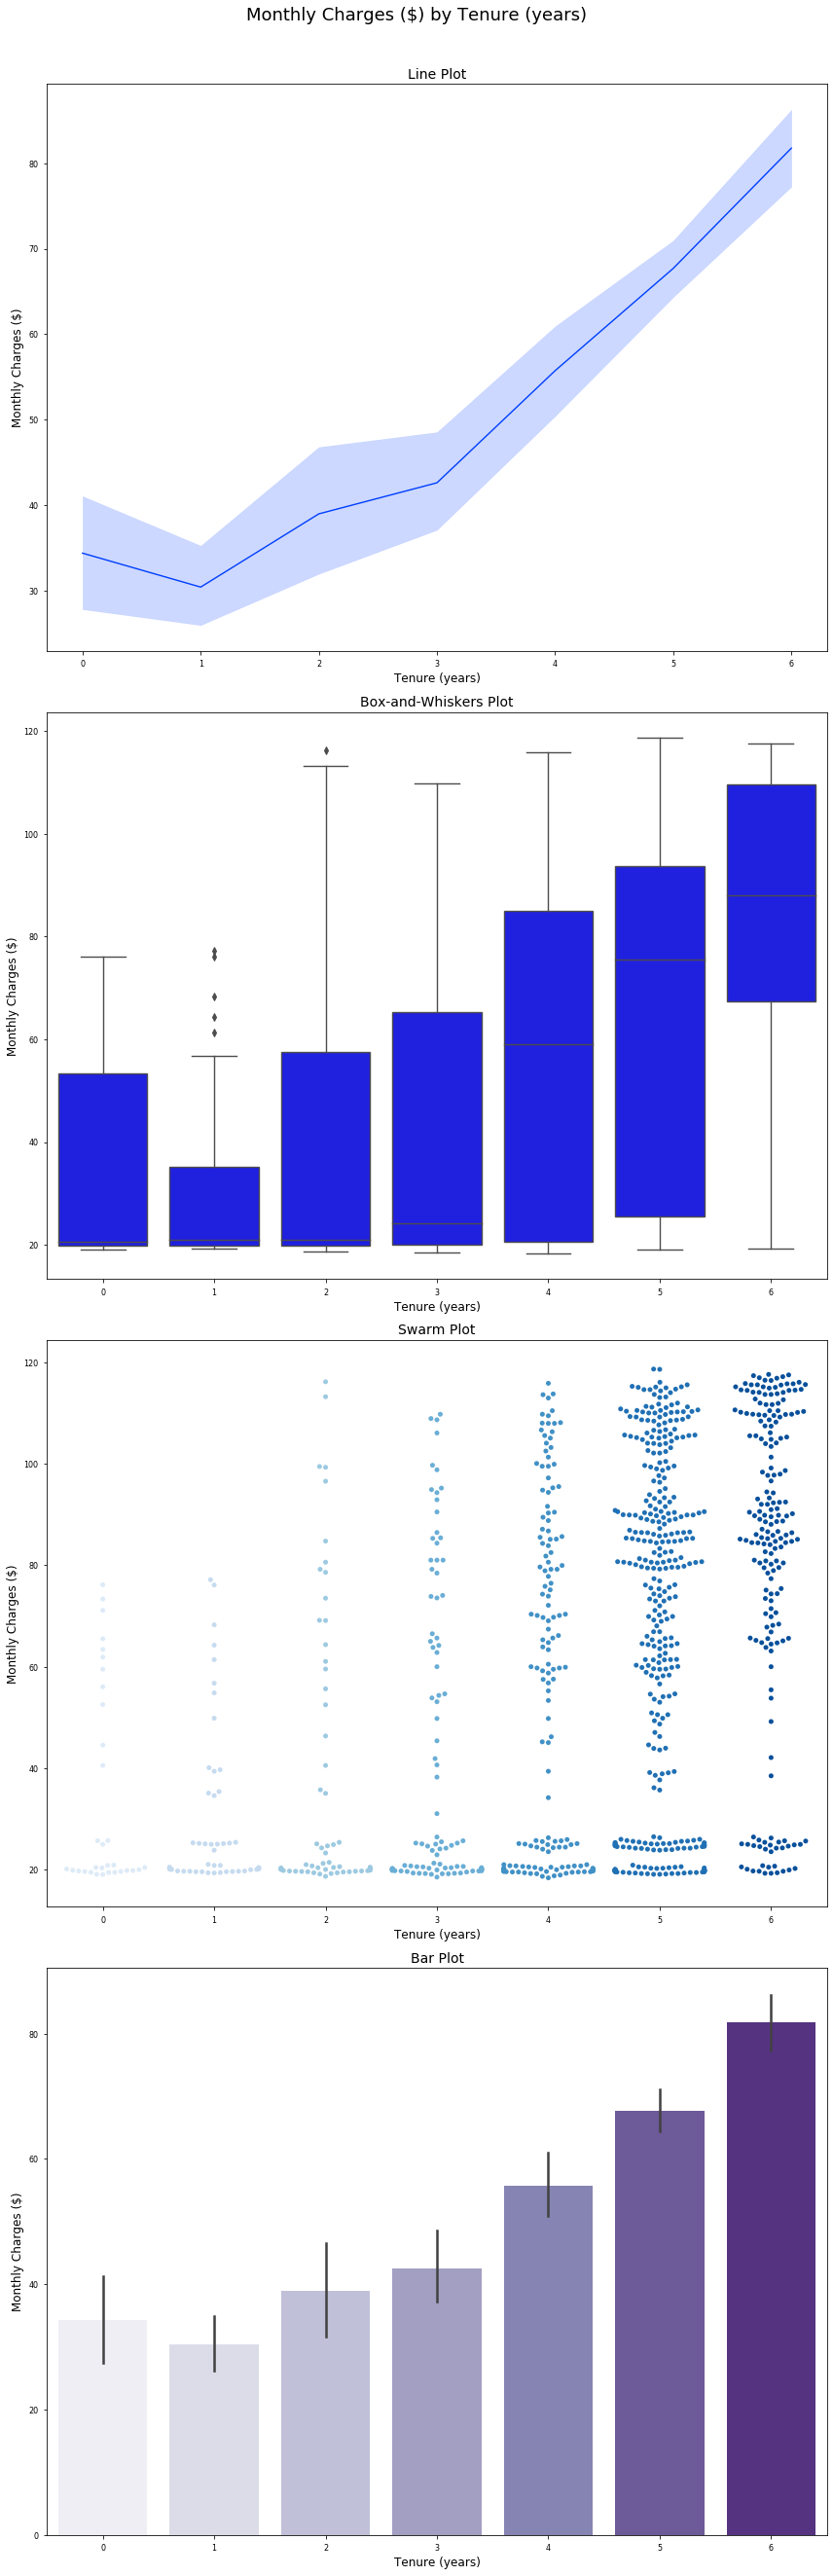

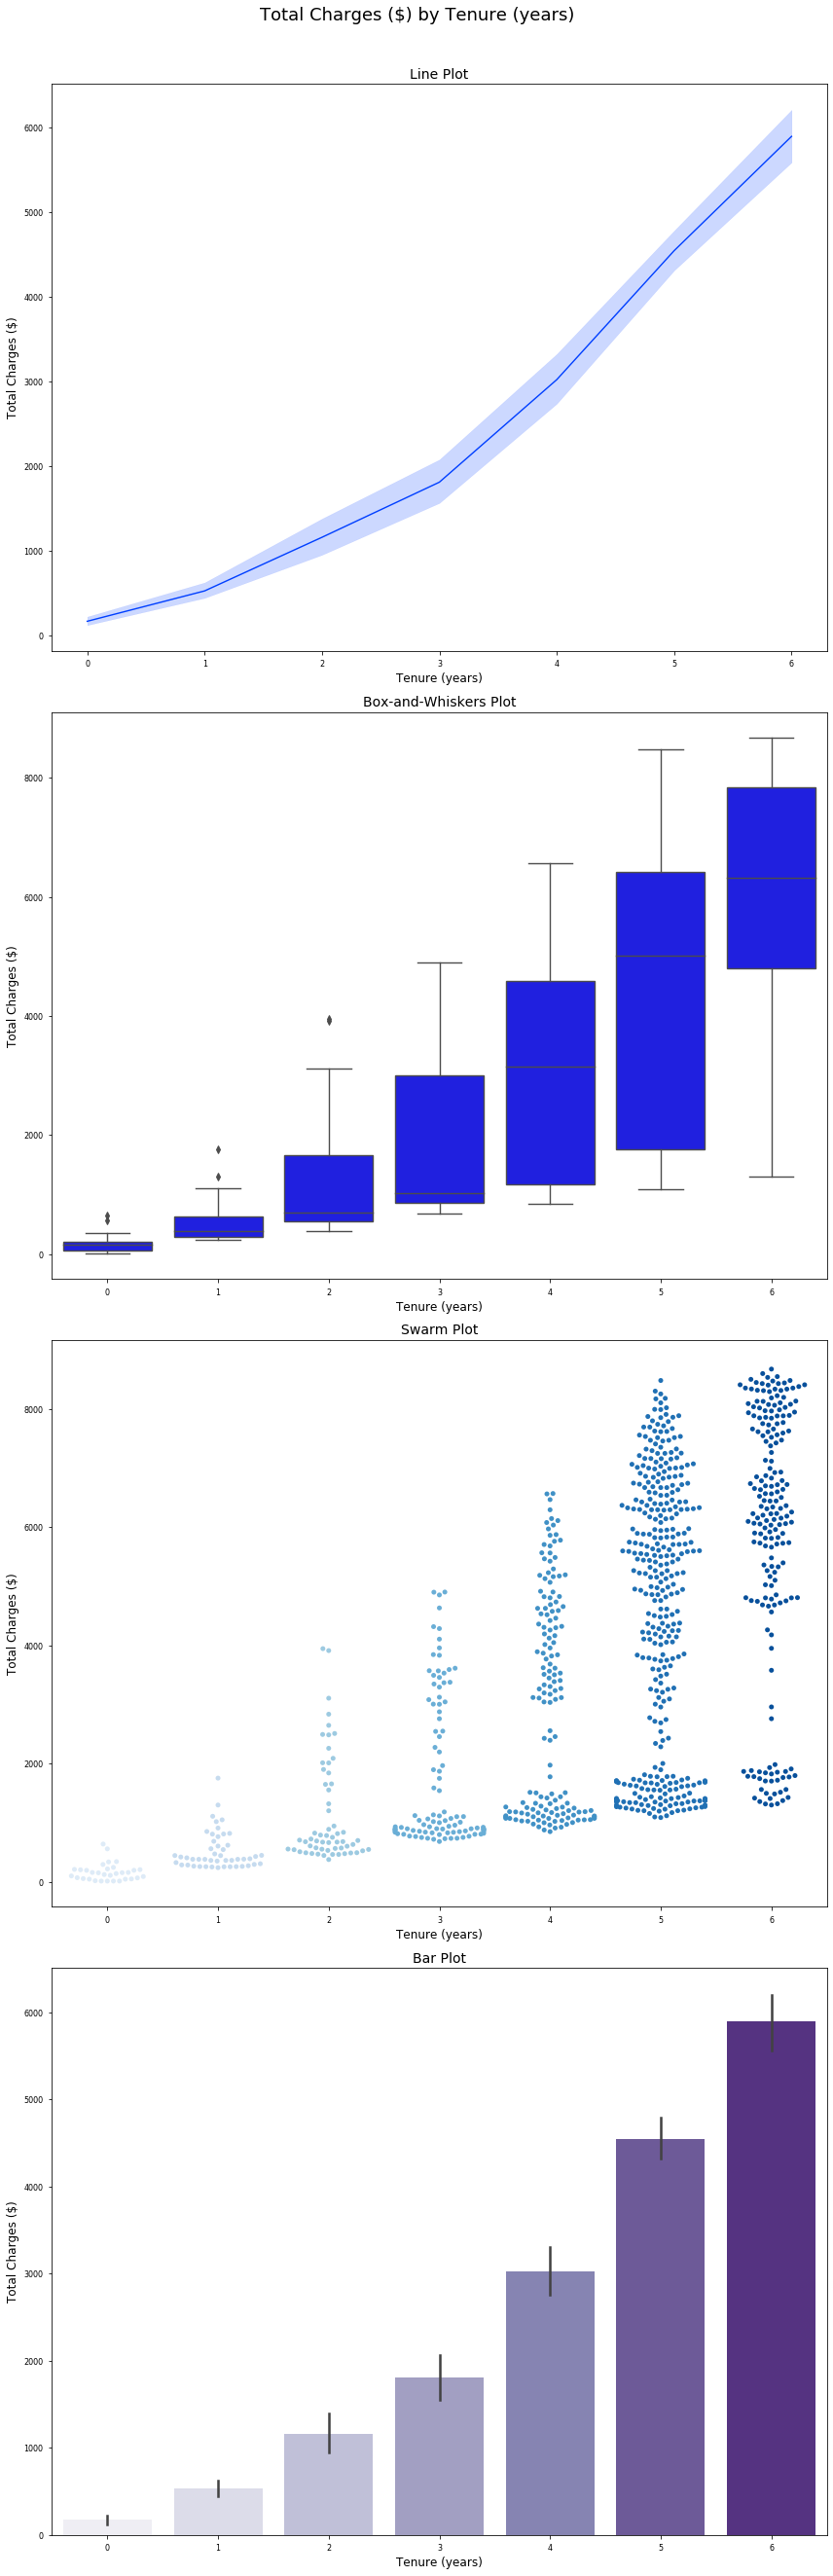

In [129]:
plot_categorical_and_continuous_vars(['tenure_years'], \
                    train.drop(columns=['customer_id', 'tenure_years', 'tenure']).columns,\
                    train, descriptive)

## Object Oriented Approach, subplots method

- figure is the container holding our plots

- axes are the actual plots

- so our plot can contain more than one axis

In [49]:
def plot_categorical_and_continuous_vars_telco(df, descriptive=None):  
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,10), nrows=3,ncols=1, sharex=True)
    plt.style.use('seaborn-bright')

    plt.suptitle('Total Charges by Tenure Years', fontsize=18)

    ax1.plot(df.tenure_years, df.total_charges, color='mediumblue')
    ax1.set_ylabel('US Dollars', fontsize=14)

    ax2.bar(df.tenure_years, df.total_charges, color='dodgerblue')
    ax2.set_ylabel('US Dollars', fontsize=14)

    ax3.scatter(df.tenure_years, df.total_charges, color='skyblue')
    ax3.set_xlabel('Tenure in Years', fontsize=14)
    ax3.set_ylabel('US Dollars', fontsize=14)

    plt.tight_layout()
    plt.show()

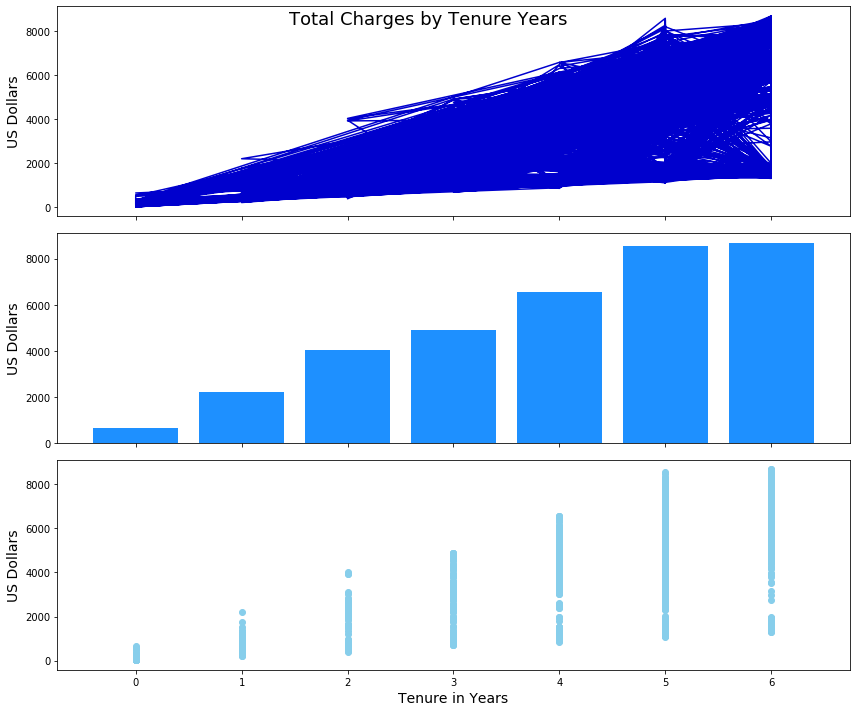

In [50]:
plot_categorical_and_continuous_vars_telco(df, descriptive)

## How about some pie?

In [51]:
def telco_pie(train):
    plt.style.use('seaborn-paper')
    labels = ['0 years', '1 years', '2 years', '3 years', '4 years', '5 years', '6 years']
    colors = ['dodgerblue', 'whitesmoke', 'whitesmoke', 'whitesmoke', 'whitesmoke', 'whitesmoke', 'whitesmoke']
    explode = (0.1, 0, 0, 0, 0, 0, 0) 
    
    plt.pie(train.tenure_years.value_counts(), explode=explode, colors=colors,\
            labels = labels, autopct='%1.0f%%', shadow=True, textprops={'fontsize':14},\
            wedgeprops={'edgecolor': 'black', 'width': 0.6})
    plt.title('Percent of Accounts by Tenure Years', fontsize=18)
    plt.show()

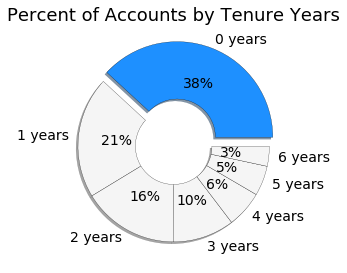

In [52]:
telco_pie(train)

## Correlation Function

In [53]:
def correlation_exploration(train, x_string, y_string):
    '''
    This function takes in a df, a string for an x-axis variable in the df, 
    and a string for a y-axis variable in the df and displays a scatter plot, the r-
    squared value, and the p-value. It explores the correlation between input the x 
    and y variables.
    '''
    r, p = stats.pearsonr(train[x_string], train[y_string])
    df.plot.scatter(x_string, y_string)
    plt.title(f"{x_string}'s Relationship with {y_string}")
    print(f'The p-value is: {p}. There is {round(p,3)}% chance that we see these results by chance.')
    print(f'r = {round(r, 2)}')
    plt.show()

The p-value is: 3.846308286137554e-115. There is 0.0% chance that we see these results by chance.
r = 0.65


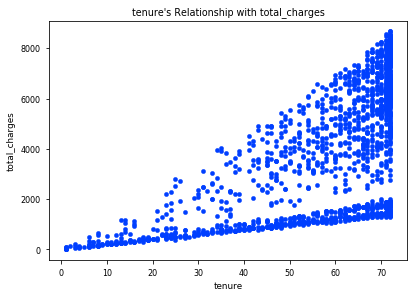

In [54]:
correlation_exploration(train, 'tenure', 'total_charges')